In [1]:
import os
import sys
import glob
import pickle
import tables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

#### TODO
1. D=2, DZA=1: damping, super-wide dead-band
1. D=2, DZA=36e-3/60: damping, realistic dead-band
1. D=0, DZA=0.36/60: no damping, wide dead-band

#### A couple of functions used in the following

In [2]:
def load_data(data_files, var_names, data_mean = None, data_std = None, window_dur = 60, window_step = 10, verbose=False):
    fids = [tables.open_file(data_file, 'r') for data_file in data_files]
    n_files = len(data_files)
    time = [fids[0].root.time.read()]
    for i in range(1, n_files):
        time.append(fids[i].root.time.read() + time[i-1][-1])
    time = np.concatenate(time)
    N_samples = time.size
    data = {var_name: np.concatenate([fid.root[var_name] for fid in fids]) for var_name in var_names}
    if data_mean is None:
        data_mean = {var_name: np.mean(data[var_name]) for var_name in var_names}
        data_std = {var_name: np.std(data[var_name]) for var_name in var_names}
    data_normalized = {var_name: (data[var_name] - data_mean[var_name]) / data_std[var_name] for var_name in var_names}
    params = fids[0].root.parameters.read()
    dt = 1 / params['frand'][0]
    window_size = int(window_dur / dt)
    if verbose:
        print('Window size: {:d} samples'.format(window_size))
    data_sliding = {}
    indexes = {}
    for var_name in var_names:
        data_sliding[var_name], indexes[var_name] = slide_window(data_normalized[var_name],
                                                                  window_size,
                                                                  window_step=window_step)
    if verbose:
        print('Number of trials: {:d}'.format(data_sliding[var_names[0]].shape[0]))

    for fid in fids:
        fid.close()
    
    return time, data, data_normalized, data_sliding, indexes


def predict(data_sliding, model, window_step, dt, rolling_length=50):
    var_names = data_sliding.keys()
    if len(model.inputs) == 2:
        x = {var_name: tf.constant(data_sliding[var_name], dtype=tf.float32) for var_name in var_names}
    elif len(model.inputs) == 1 and len(data_sliding.keys()) == 2:
        x = tf.constant(list(data_sliding.values()), dtype=tf.float32)
        x = tf.transpose(x, perm=(1,2,0))
    else:
        x = tf.constant(data_sliding[var_names[0]], dtype=tf.float32)
    y = np.squeeze(model.predict(x))
    H = pd.DataFrame(data = {'inertia': y}).rolling(rolling_length).mean().to_numpy()
    time = np.arange(H.size) * window_step * dt
    return time, H, y

In [3]:
### D = 2  DZA = 60
# no ReLU
# experiment_ID = 'f0dc559c19584ecb82668b0f585819e8' # MAPE = 0.54%
# ReLU after convolution
experiment_ID = '2bfabe9a6a7d46c389fec10fb198bfed'  # MAPE = 0.50%
# ReLU after pooling
# experiment_ID = 'f9b54681f58f4bf3a417a86646e8f57e'  # MAPE = 0.65%
# ReLU after pooling - no Pe
#experiment_ID = '465ab6a9d3af45048d7d31b84c5ee68b'
#experiment_ID = 'd7f30fef5806435897e97f27606fa30a'
# no ReLU - 2D convolution
# experiment_ID = '67dd7c399e1d4b18a0a78fc1bcc589c6'  # MAPE = 0.81%

### D = 2  DZA = 0.036
# no ReLU
# experiment_ID = '62c738aa78494601be167e9cdfeb788f'  # MAPE = 0.75%
# experiment_ID = 'a40cb482442046cc8d69df5b1b6b0469'  # MAPE = 0.82%
# ReLU after convolution
# experiment_ID = '22616aa16c484eaf9c0fde653a4c9989'  # MAPE = 0.89%

### D = 0  DZA = 0.36
# no ReLU
# experiment_ID = 'e44fa1f69054480baa2d0ca890c82e9e'  # MAPE = 0.82%

In [4]:
experiments_path = '../experiments/'
checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(experiments_path + experiment_ID \
                                      + '/parameters.pkl', 'rb'))
val_loss = [float(file[:-3].split('-')[-1]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[np.argmin(val_loss)]
model = keras.models.load_model(best_checkpoint, compile=True)
data_dir = '../' + network_parameters['data_dir']
# we need mean and standard deviation of the training set to normalize the data
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
print('Loaded network from {}.'.format(best_checkpoint))
print('Data directory is {}.'.format(data_dir))

Loaded network from ../experiments/2bfabe9a6a7d46c389fec10fb198bfed/checkpoints/weights.728-0.02.h5.
Data directory is ../data/IEEE14_D=2_DZA=60.0.


In [5]:
comet_api = API(api_key = os.environ['COMET_ML_API_KEY'])
experiments = comet_api.get(workspace='danielelinaro', project_name='inertia')
for experiment in experiments:
    if experiment.id == experiment_ID:
        metrics = experiment.get_metrics()
        for m in metrics:
            if m['metricName'] == 'mape_prediction':
                mape = float(m['metricValue'])
                break
        break
print(f'Experiment {experiment_ID[:9]} has a MAPE of {mape:.2f}%.')

Experiment 2bfabe9a6 has a MAPE of 0.50%.


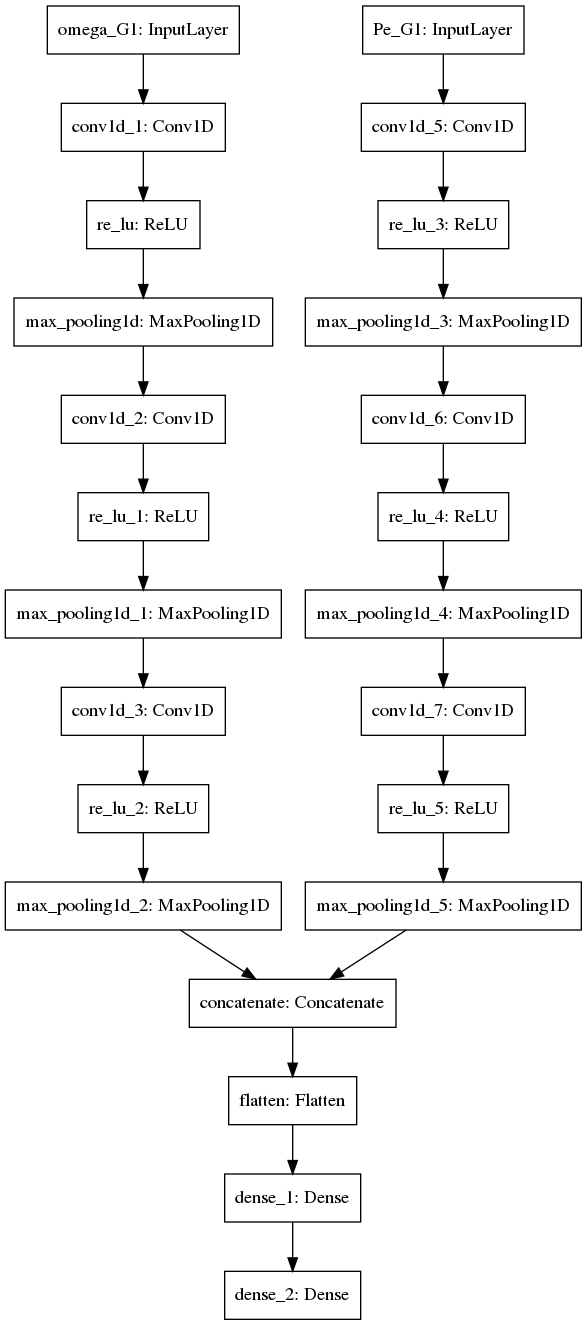

In [6]:
keras.utils.plot_model(model, show_shapes=False, dpi=96)

### Step of inertia
1. H steps **instantaneously** from 3.5 to 8.5
1. **omega** and **Pe** of the first generator used for the estimation
1. two simulations joined together (i.e., **no transient** during the step)

In [7]:
window_dur = 60
window_step = 10
H_values = [3.5, 3.8]
data_files = [f'{data_dir}/H_{h:.3f}.h5' for h in H_values]
gen_id = 1
var_names = [f'omega_G{gen_id}', f'Pe_G{gen_id}']
if gen_id == 1:
    data_mean = {var_name: x_train_mean[i] for i,var_name in enumerate(var_names)}
    data_std = {var_name: x_train_std[i] for i,var_name in enumerate(var_names)}
else:
    data_mean = None
    data_std = None
t, data, data_normalized, data_sliding, _ = load_data(data_files,
                                                      var_names,
                                                      data_mean,
                                                      data_std,
                                                      window_dur,
                                                      window_step,
                                                      verbose=True)
dt = np.diff(t[:2])[0]
time, H, _ = predict(data_sliding, model, window_step, dt)

Window size: 600 samples
Number of trials: 7140


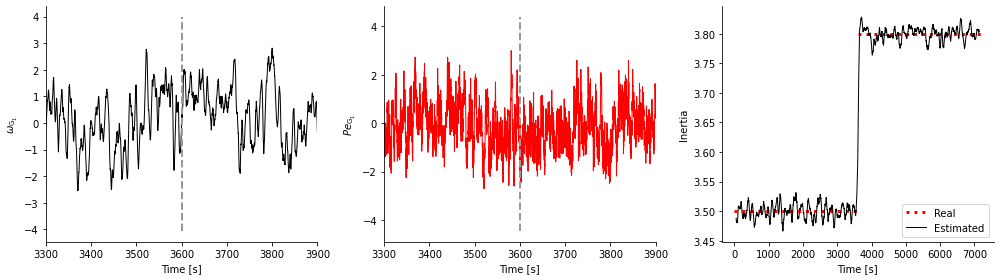

In [8]:
fig,ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].plot(t, data_normalized[var_names[0]], 'k', lw=1)
ax[0].plot([3600, 3600], ax[0].get_ylim(), '--', lw=2, color=[.6,.6,.6])
ax[1].plot(t, data_normalized[var_names[1]], 'r', lw=1)
ax[1].plot([3600, 3600], ax[0].get_ylim(), '--', lw=2, color=[.6,.6,.6])
ax[2].plot([0, 3600], H_values[0] + np.zeros(2), 'r:', lw=3)
ax[2].plot([3600, 7200], H_values[1] + np.zeros(2), 'r:', lw=3, label='Real')
ax[2].plot(time, H, 'k', lw=1, label='Estimated')

ax[2].legend(loc='lower right')
ax[0].set_ylabel(r'$\omega_{\mathrm{G}_1}$')
ax[1].set_ylabel(r'$Pe_{\mathrm{G}_1}$')
ax[2].set_ylabel('Inertia')
for a in ax:
    a.set_xlabel('Time [s]')
    if a != ax[2]:
        a.set_xlim([3300, 3900])
    for side in 'right','top':
        a.spines[side].set_visible(False)

fig.tight_layout()

### Ramp of inertia
H steps **gradually** from 3.5 to 6.5 in 100 seconds (from t = 3550s to t=3650s)